In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/IASAE/aclImdb/train'

# CHARGEMENT INTELLIGENT
def load_and_parse_imdb(directory):
    data = []
    print(f"📂 Démarrage du chargement depuis : {directory}")

    # parcourt dossiers 'pos' et 'neg'
    for label in ['pos', 'neg']:
        path = os.path.join(directory, label)
        if not os.path.exists(path):
            print(f"Le dossier {path} n'existe pas")
            continue

        print(f"   -> Traitement du dossier '{label}'")
        files = os.listdir(path)

        for filename in files:
            if filename.endswith(".txt"):
                file_path = os.path.join(path, filename)

                # EXTRACTION NOTE 
                # fichiers sont nommés "ID_NOTE.txt" (ex : 1234_10.txt)
                try:
                    # on prend la partie après le '_' et avant le '.'
                    rating = int(filename.split('_')[1].split('.')[0])
                except:
                    rating = None # au cas où

                # lecture
                with open(file_path, 'r', encoding='utf-8') as f:
                    review = f.read()

                data.append({
                    'text': review,
                    'sentiment': 1 if label == 'pos' else 0, # 1=Positif, 0=Négatif
                    'rating': rating,
                    'filename': filename
                })

    # conversion DataFrame Pandas
    df = pd.DataFrame(data)

    # mélange aléatoire pour ne pas avoir tous les positifs au début
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"✅ Chargement terminé : {len(df)} critiques récupérées.")
    return df

df = load_and_parse_imdb(BASE_PATH)
df.head()

Mounted at /content/drive
📂 Démarrage du chargement depuis : /content/drive/MyDrive/Colab Notebooks/IASAE/aclImdb/train
   -> Traitement du dossier 'pos'...
   -> Traitement du dossier 'neg'...
✅ Chargement terminé : 24977 critiques récupérées.


,text,sentiment,rating,filename
0,"When I saw this film on FearNet, I thought it ...",0,2,7947_2.txt
1,Another reason to watch this delightful movie ...,1,10,4138_10.txt
2,Every once in a while the conversation will tu...,1,10,10048_10.txt
3,Definitely an odd debut for Michael Madsen. Ma...,0,1,7809_1.txt
4,"Back in the forties, when movies touched on ma...",1,9,3837_9.txt


🧹 Nettoyage des textes en cours...


/tmp/ipython-input-3743790945.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


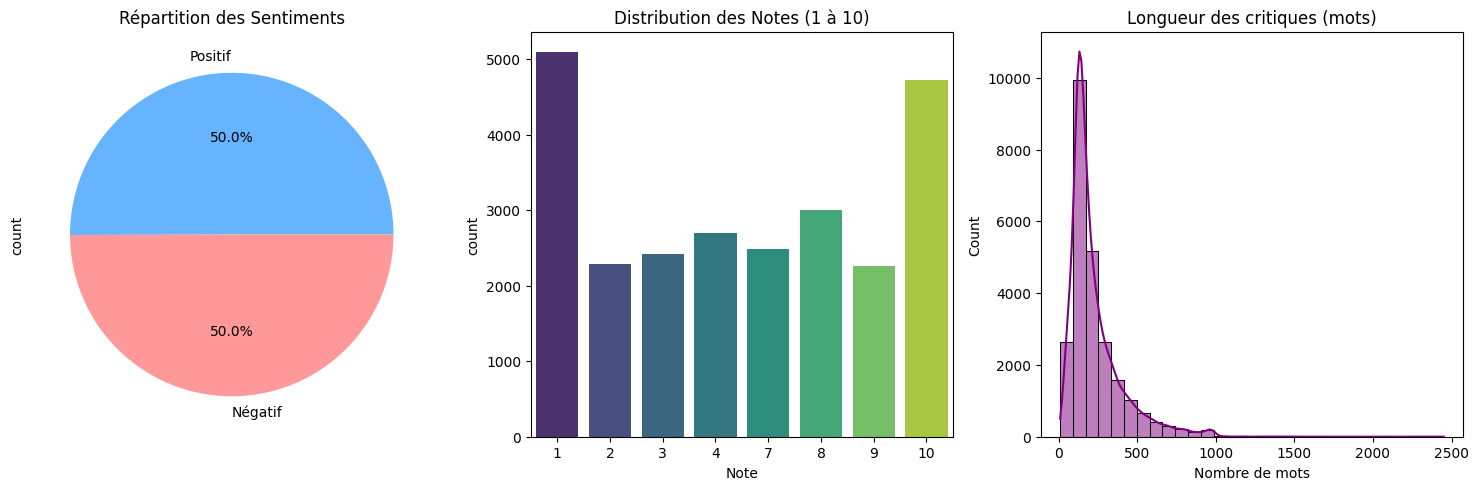


☁️ Génération du nuage de mots...


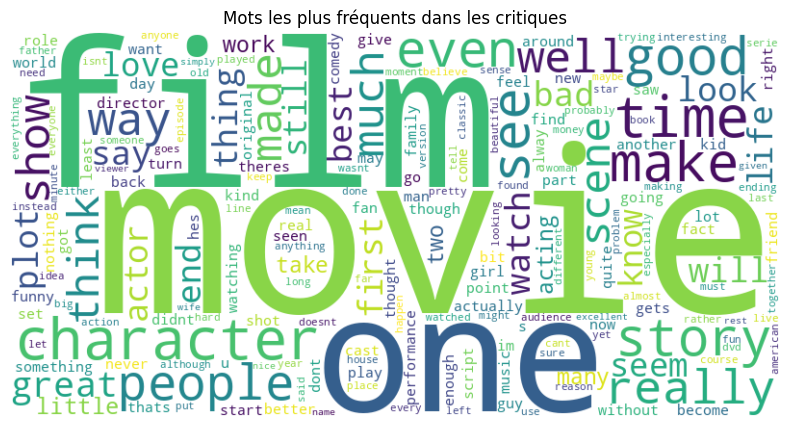

In [ ]:
# NETTOYAGE TEXTE
def clean_text_frugal(text):
    # suppression des balises HTML <br />
    text = re.sub(r'<br\s*/?>', ' ', text)
    # on ne garde que les lettres (suppression ponctuation et chiffres)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # minuscule et suppression espaces inutiles
    text = text.lower().strip()
    return text

print("Nettoyage des textes en cours")
df['clean_text'] = df['text'].apply(clean_text_frugal)

# calcul du nombre de mots pour l'analyse
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

# VISUALISATIONS
plt.figure(figsize=(15, 5))

# graphique A : répartition des sentiments
plt.subplot(1, 3, 1)
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], labels=['Positif', 'Négatif'])
plt.title("Répartition des sentiments")

# graphique B : distribution des notes
plt.subplot(1, 3, 2)
sns.countplot(x='rating', data=df, palette='viridis')
plt.title("Distribution des notes (1 à 10)")
plt.xlabel("Note")

# graphique C : longueur des critiques
plt.subplot(1, 3, 3)
sns.histplot(df['word_count'], bins=30, color='purple', kde=True)
plt.title("Longueur des critiques (mots)")
plt.xlabel("Nombre de mots")

plt.tight_layout()
plt.show()

# WordCloud
print("\n Génération du nuage de mots")
all_text = " ".join(t for t in df['clean_text'].iloc[:5000]) # sur un échantillon pour aller vite
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Mots les plus fréquents dans les critiques")
plt.show()

In [ ]:
# PRÉPARATION DES DONNÉES 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# variables cibles
X = df['clean_text']
y_sent = df['sentiment'] # pour modèle 1
y_rate = df['rating']    # pour modèle 2

# séparation Train (80%) / Test (20%)
# random_state=42 toujours le même résultat
X_train, X_test, y_sent_train, y_sent_test, y_rate_train, y_rate_test = train_test_split(
    X, y_sent, y_rate, test_size=0.2, random_state=42
)

print(f"Données divisées : {len(X_train)} Entraînement / {len(X_test)} Test")

# vectorisation TF-IDF (Frugale : max 5000 mots)
print("Vectorisation TF-IDF en cours.")
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# on apprend le vocabulaire sur le train et on transforme le test
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

print("Vectorisation terminée (textes => matrices numériques")

📊 Données divisées : 19981 Entraînement / 4996 Test
🧮 Vectorisation TF-IDF en cours...
✅ Vectorisation terminée. Les textes sont maintenant des matrices numériques.
